In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
from sklearn.covariance import EmpiricalCovariance
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import scipy.optimize as opt
from sklearn.linear_model import LinearRegression

In [2]:
data = pd.read_csv("gp_data_1986_to_2015.csv")
data.head(5)

,Month,Mkt-RF,RF,Agric,Food,Soda,Beer,Smoke,Toys,Fun,...,BusSv,Comps,Chips,LabEq,Paper,Boxes,Trans,Whlsl,Rtail,Meals
0,198601,0.65,0.56,7.92,2.38,-1.20,-0.86,5.55,2.14,3.91,...,0.78,-1.11,0.85,3.80,4.61,1.91,5.60,2.48,1.67,-0.09
1,198602,7.13,0.53,13.98,7.89,11.68,7.71,12.20,10.72,8.28,...,7.47,2.71,8.34,9.98,8.68,10.61,7.03,8.85,7.21,9.27
2,198603,4.88,0.60,2.74,7.84,10.89,9.17,11.52,5.65,6.86,...,4.96,-0.11,0.04,-1.15,4.18,5.61,3.22,7.41,9.11,6.42
3,198604,-1.31,0.52,5.24,-0.57,4.44,-2.92,3.64,3.91,8.36,...,3.33,3.87,3.55,2.69,-2.50,-0.93,-2.64,1.70,-0.70,3.86
4,198605,4.62,0.49,1.08,8.55,7.95,6.37,10.16,3.16,5.91,...,5.41,1.01,-0.75,2.51,6.66,5.07,0.70,5.52,11.95,4.89


## 1.1 Pre-processing

In [3]:
# Replace the return rate of every asset with the excess return rate (E[r_i]-r_f) and convert to decimal 

#cleaning the data to divide by 100
for c in data.columns: 
    if c in ['Month']:
        continue 
    data[c] = data[c]

# Calculate the risk-free rate for all assets
Rf = data['RF'].values.copy()
for column in data.columns:
    if column in ['Month','Mkt-RF','RF']:
        continue
    data[column] -= Rf      # to subtract Rf.values from all columns in df, other than "Month" & "Mkt-RF"

In [4]:
data

,Month,Mkt-RF,RF,Agric,Food,Soda,Beer,Smoke,Toys,Fun,...,BusSv,Comps,Chips,LabEq,Paper,Boxes,Trans,Whlsl,Rtail,Meals
0,198601,0.65,0.56,7.36,1.82,-1.76,-1.42,4.99,1.58,3.35,...,0.22,-1.67,0.29,3.24,4.05,1.35,5.04,1.92,1.11,-0.65
1,198602,7.13,0.53,13.45,7.36,11.15,7.18,11.67,10.19,7.75,...,6.94,2.18,7.81,9.45,8.15,10.08,6.50,8.32,6.68,8.74
2,198603,4.88,0.60,2.14,7.24,10.29,8.57,10.92,5.05,6.26,...,4.36,-0.71,-0.56,-1.75,3.58,5.01,2.62,6.81,8.51,5.82
3,198604,-1.31,0.52,4.72,-1.09,3.92,-3.44,3.12,3.39,7.84,...,2.81,3.35,3.03,2.17,-3.02,-1.45,-3.16,1.18,-1.22,3.34
4,198605,4.62,0.49,0.59,8.06,7.46,5.88,9.67,2.67,5.42,...,4.92,0.52,-1.24,2.02,6.17,4.58,0.21,5.03,11.46,4.40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
355,201508,-6.04,0.00,-4.59,-4.22,-4.57,-3.12,-4.06,-4.83,-7.79,...,-5.40,-8.20,-5.53,-7.60,-5.98,-3.58,-6.36,-4.27,-5.42,-6.48
356,201509,-3.07,0.00,-11.16,-1.73,2.15,2.58,2.37,-5.42,-10.75,...,-1.47,-2.35,-0.82,-4.79,-2.33,-4.97,-0.72,-6.00,-1.72,0.44
357,201510,7.75,0.00,8.63,5.44,5.77,8.06,10.90,11.86,15.14,...,11.41,5.87,8.88,7.56,10.25,9.78,6.47,5.17,4.53,5.05
358,201511,0.56,0.00,1.87,-1.59,2.36,-0.71,-3.00,-2.23,-0.08,...,2.11,-3.03,0.23,5.24,0.02,-0.32,-1.11,2.70,0.59,-1.01


## 1.2 Basic construction and in-sample analysis (using 1986-2015)

In [5]:
#getting returns on just the 43 risky assets
data1 = data.iloc[:,3:]
data1.head(5)

,Agric,Food,Soda,Beer,Smoke,Toys,Fun,Books,Hshld,Clths,...,BusSv,Comps,Chips,LabEq,Paper,Boxes,Trans,Whlsl,Rtail,Meals
0,7.36,1.82,-1.76,-1.42,4.99,1.58,3.35,-1.34,-1.52,4.66,...,0.22,-1.67,0.29,3.24,4.05,1.35,5.04,1.92,1.11,-0.65
1,13.45,7.36,11.15,7.18,11.67,10.19,7.75,14.14,10.20,8.80,...,6.94,2.18,7.81,9.45,8.15,10.08,6.50,8.32,6.68,8.74
2,2.14,7.24,10.29,8.57,10.92,5.05,6.26,4.47,4.97,5.57,...,4.36,-0.71,-0.56,-1.75,3.58,5.01,2.62,6.81,8.51,5.82
3,4.72,-1.09,3.92,-3.44,3.12,3.39,7.84,-1.66,-2.18,-3.30,...,2.81,3.35,3.03,2.17,-3.02,-1.45,-3.16,1.18,-1.22,3.34
4,0.59,8.06,7.46,5.88,9.67,2.67,5.42,10.47,4.12,9.29,...,4.92,0.52,-1.24,2.02,6.17,4.58,0.21,5.03,11.46,4.40


##### Getting performance metrics of the MKT, EWP, TAN and GMW 

In [6]:
def estimate_V (data):
    
    ###########
    # (Basic) Estimate of the covariance matrix from histrocial return data
    # Input: Histrocial return data
    # Output: The basic estimate of covariance matrix of asset returns
    ###########
    
    Vhat = EmpiricalCovariance().fit(data).covariance_
    
    return Vhat

def estimate_mu (data):
    
    ###########
    # (Basic) Estimate of the expected return vector from histrocial return data
    # Input: Histrocial return data
    # Output: The basic estimate of expected return vector of all assets
    ###########
    
    mu_hat = EmpiricalCovariance().fit(data).location_
    
    return mu_hat

In [7]:
#get expected returns std from 43 assets
returns = estimate_mu(data1)
sd = data1.std()

#sharpe ratio: excess returns/sd
sharpe_r = returns/sd

#combine this into a dataframe
#compile results 
industry_metric = pd.DataFrame({
    'Expected Return': returns,
    'Standard Deviation':sd.values,
    'Sharpe Ratio': sharpe_r.values
})

#change the index of industry metric to portfolio names 
industry_metric.index = data1.columns

In [8]:
#getting the beta for 43 risky assets, estimated from covariance 
def estimate_beta_cov(portfolio, market_excess):
    covariance = np.cov(portfolio, market_excess)[0, 1]
    variance_market = np.var(market_excess)
    beta = covariance / variance_market
    return beta

market_excess = data['Mkt-RF']
beta = data1.apply(lambda x: estimate_beta_cov(x, market_excess))

industry_metric['Beta'] = beta
industry_metric

,Expected Return,Standard Deviation,Sharpe Ratio,Beta
Agric,0.700861,6.400108,0.109508,0.783470
Food,0.836806,4.452608,0.187936,0.601572
Soda,0.899500,7.002115,0.128461,0.827677
Beer,0.991889,5.107061,0.194219,0.641080
Smoke,1.254278,6.847884,0.183163,0.634679
Toys,0.531028,6.706478,0.079181,1.047238
Fun,0.940722,7.596395,0.123838,1.348033
Books,0.480139,5.725771,0.083856,1.033395
Hshld,0.667972,4.499215,0.148464,0.718600
Clths,0.822778,6.574475,0.125147,1.085348


### Construct EWP, MKT, TAN, GMV

In [9]:
def ewp(n):
    
    ###########
    # Construct the equally weighted portfolio
    # Input: n is the number of assets
    #        NB: neither the expected return vector nor covariance matrix is not needed here!
    # Output: The weights of the equally weighted portfolio
    ###########

    #GMV
    
    return np.ones(n)/n

def tangency(mu, V):
    
    #tangency portfolio
    w_t = np.linalg.inv(V) @ mu
    w_t /= np.sum(w_t)

    return w_t

def gmv(V):
    
    #GMV: minimise sigma for all given r 
    n = len(V)
    w_g = np.linalg.inv(V) @ np.ones(n)
    w_g /= np.sum(w_g)
    
    return w_g

def evaluate_portfolio_performance_on_data(w, data_evaluate):
    
    ###########
    # Evaluate the performance of a portfolio (i.e., weight vector) given the return data to evaluate on
    # Input: data contains historical return information (every column corresponds to an asset)
    #        w is the portfolio weight vector
    #        (NB: risk-free rate has already been assumed to be zero)
    # Output: The performance metrics of the portfolio 
    #         (i.e., expected return, standard deviation, variance, and Sharpe ratio)
    ###########
    
    # Sanity check for the input format
    w = w.reshape((-1))
    if (data_evaluate.shape[1] != len(w)):
        print('Warning: data and w should contain the same number of assets')
    ### End of sanity check
    
    V = estimate_V (data_evaluate)
    mu = estimate_mu (data_evaluate)
    
    
    return {'Er': mu.T @ w, 'sigma': np.sqrt(w.T @ V @ w), 
            'var': w.T @ V @ w, 'Sharpe': (mu.T @ w - 0)/(np.sqrt(w.T @ V @ w)) }

In [10]:
def get_EF_on_data (w_t, w_g, data_evaluate):

    ###########
    # Get the (evaluated) efficient frontier curve using the two-fund separation method
    #
    # Input: data contains historical return information to evaluate on (every column corresponds to an asset)
    #        w_t and w_g are the constructed tangency and global minimum variance portfolios, respectively
    #        (NB: if w_t and w_g are obtained from the training data but "data" is actually testing data,
    #         then the output EF could be highly sub-optimal!)
    # Output: The risk-return combinations of portfolios on the (evaluated) EF 
    ###########
    
    trange = np.arange(0,2,0.01)
    sigma_range = np.zeros_like (trange) * np.nan
    Er_range = np.zeros_like (trange) * np.nan

    for i in np.arange(len(trange)):
        w_mix = trange[i] * w_t + (1-trange[i]) * w_g
        sigma_range[i] = evaluate_portfolio_performance_on_data (w_mix, data_evaluate) ['sigma']
        Er_range[i] = evaluate_portfolio_performance_on_data (w_mix, data_evaluate) ['Er']
        
    return sigma_range, Er_range


### 1.2 (1) 3x4 table Summary of performance metrics: er, sigma, beta for MKT, EWP, TAN, GMV

In [11]:
# Obtain the tangency, GMV, equally weighted portfolios
#get expected returns std from 43 assets
#returns = estimate_mu(data1)
#sd = data1.std()
V = estimate_V(data1)
mkt_er = data['Mkt-RF'].mean()
mkt_sd = data['Mkt-RF'].std()
mkt_sharpe = mkt_er / mkt_sd

w_t = tangency(returns, V)
w_g = gmv(V)
w_e = ewp(data1.shape[1])


# getting performance metrics
metric_ewp = evaluate_portfolio_performance_on_data(w_e, data1)
metric_tan = evaluate_portfolio_performance_on_data(w_t, data1)
metric_gmv = evaluate_portfolio_performance_on_data(w_g, data1)

#convert to 3x4 table 
performance_summary = pd.DataFrame({
    'Portfolio': ['MKT','EWP', 'TAN', 'GMV'],
    'Expected Return': [mkt_er, metric_ewp['Er'], metric_tan['Er'], metric_gmv['Er']],
    'Standard Deviation': [mkt_sd, metric_ewp['sigma'], metric_tan['sigma'], metric_gmv['sigma']],
    'Sharpe Ratio': [mkt_sharpe, metric_ewp['Sharpe'], metric_tan['Sharpe'], metric_gmv['Sharpe']]
})

# Set the 'Portfolio' column as the index for better visualization
performance_summary.set_index('Portfolio', inplace=True)

# Display the summary table
performance_summary.T

Portfolio,MKT,EWP,TAN,GMV
Expected Return,0.636361,0.718348,1.916838,0.562142
Standard Deviation,4.484527,4.650387,5.281517,2.860151
Sharpe Ratio,0.141902,0.154470,0.362933,0.196543


### 1.2 (2a) sigma vs ER diagram for 43 risky assets, EWP, TAN, GMV & MKT, and in-sample EF

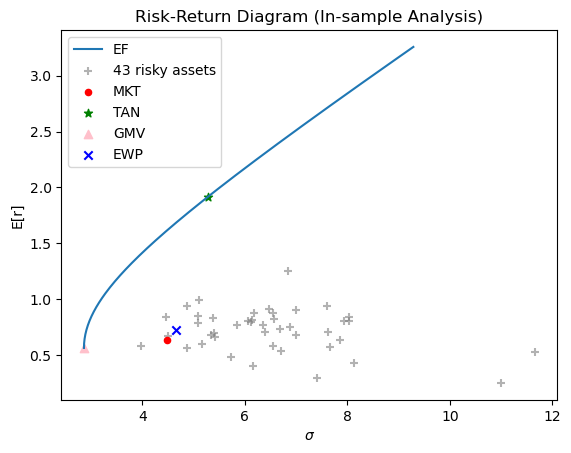

In [12]:

sigma_range, Er_range = get_EF_on_data (w_t, w_g, data1)
plt.plot(sigma_range, Er_range, label = 'EF')

#plot the 43 risky assets risk-return
plt.scatter(sd, returns, marker='+', color='grey',alpha=0.6,label="43 risky assets")

#plot the MKT portfolio
plt.scatter(mkt_sd, mkt_er,marker='o', color='r',label="MKT",s=20)

# tangency portfolio (TAN)
plt.scatter(metric_tan['sigma'], metric_tan['Er'], 
            marker='*', color = 'green',label = 'TAN')

# global minimum variance portfolio (GMV)
plt.scatter(metric_gmv['sigma'], metric_gmv['Er'], 
            marker='^', color = 'pink',label = 'GMV')

# equally weighted portfolio (EWP)
plt.scatter(metric_ewp['sigma'], metric_ewp['Er'], 
            marker='x', color = 'blue',label = 'EWP')


plt.legend()
plt.title('Risk-Return Diagram (In-sample Analysis)')
plt.xlabel('$\sigma$ ')
plt.ylabel('E[r]')

plt.show()

### 1.2 (2b) Plotting the beta and exp return diagram

In [13]:
#beta of a portfolio = weighted average of asset beta

#TAN beta
beta_tan = np.dot(w_t, beta)

# gmv beta
beta_gmv = np.dot(w_g, beta)

# ewp beta
beta_ewp = np.dot(w_e, beta)

#mkt beta 
beta_mkt = 1

In [14]:
#CAPM line
beta_range = np.linspace(-0.5, 1.75, 100)

capm_returns = []

for i in beta_range: 
    capm = 0 + i * mkt_er
    capm_returns.append(capm)


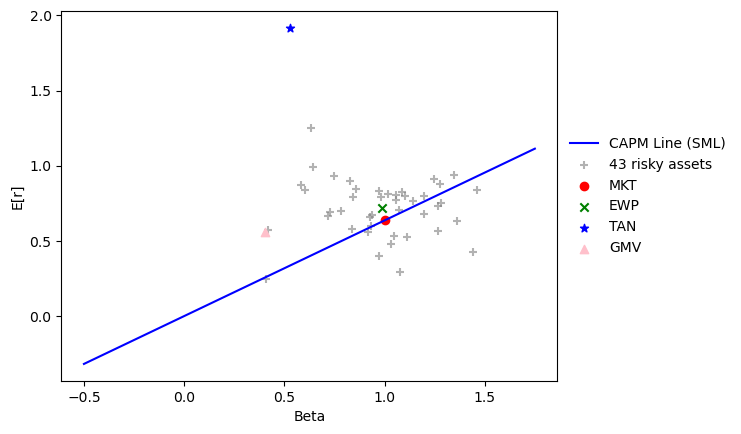

In [15]:
#plot the CAPM line
plt.plot(beta_range, capm_returns, color="blue", label="CAPM Line (SML)")

#plot the 43 portfolios 
plt.scatter(beta, returns, marker='+', color='grey',alpha=0.6,label="43 risky assets")

#plot the MKT portfolio
plt.scatter(beta_mkt, mkt_er,marker='o', color='r',label="MKT")

#plot the EWP 
plt.scatter(beta_ewp, metric_ewp['Er'], 
            marker='x', color = 'green',label = 'EWP')

#plot tangency 
plt.scatter(beta_tan, metric_tan['Er'], 
            marker='*', color = 'blue',label = 'TAN')

#plot GMV
plt.scatter(beta_gmv, 
            metric_gmv['Er'], 
            marker='^', color = 'pink',label = 'GMV')

# Move legend outside bc SML was covered
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), frameon=False)  
plt.xlabel('Beta')
plt.ylabel('E[r]')
plt.show()

## 1.3 Robust portfolio construction & Out-of-sample analysis

In [16]:
# train and test split, train: 1986 - 2010, test: 2011-2015, only the 43 stocks
data_train_m = data.iloc[:300] #including Mkt-RF
data_test_m = data.iloc[300:] #including Mkt-RF

data_train = data.iloc[:300,3:]
data_test = data.iloc[300:,3:]

In [17]:
#make sure test data starts from Jan 2011
data_test_m.head()

,Month,Mkt-RF,RF,Agric,Food,Soda,Beer,Smoke,Toys,Fun,...,BusSv,Comps,Chips,LabEq,Paper,Boxes,Trans,Whlsl,Rtail,Meals
300,201101,1.99,0.01,5.00,-1.93,1.85,-3.63,-3.30,-6.73,3.58,...,2.55,3.78,6.48,3.97,2.93,3.66,-0.49,2.79,-1.29,-2.40
301,201102,3.49,0.01,-1.21,6.74,3.19,0.59,8.64,6.17,1.23,...,2.12,1.62,4.02,4.80,3.16,4.26,1.41,2.96,1.37,3.91
302,201103,0.46,0.01,0.32,1.63,4.57,3.34,6.32,1.58,-1.04,...,-0.05,-2.85,-3.25,1.67,1.83,0.43,3.00,1.46,0.47,1.84
303,201104,2.90,0.00,-4.16,5.70,5.20,3.90,5.39,4.44,6.42,...,2.66,2.03,4.74,3.64,1.96,0.67,2.93,4.06,5.20,1.40
304,201105,-1.27,0.00,2.86,2.14,3.66,0.49,4.50,-0.79,-0.51,...,-2.25,-1.74,-0.75,0.20,-0.65,5.71,-0.44,1.20,0.21,4.17


In [18]:
def estimate_beta_shrink(data, market_excess):
    #beta-hat is estimated from the sample covariance with MKT
    #beta_avg is average of beta across all industries
    beta_hat = data.apply(lambda x: estimate_beta_cov(x, market_excess))
    beta_avg = beta_hat.mean() 
    
    beta_shrink = 0.5 * beta_hat + 0.5* beta_avg
    return beta_shrink

def estimate_exp_return(beta_shrink,data_mkt):
    # beta will be from beta_shrink
    mu_CAPM = 0 + (beta_shrink * data_mkt['Mkt-RF'].mean()) #rf rate = 0
    return mu_CAPM

def estimate_shrink_cov_m(data):
    V_hat = estimate_V(data) #sample covariance matrix
    
    #intialise V_cc from formula of constant correation where 
    # V-cc = sigma_i * sigma_j * constant rho
    # constant rho = sum of all correlations / [n(n-1)/2]
    # _______________________________________________________
    V_cc = np.zeros((43,43)) 
    var = data.var().values
    corr = data.corr().values
    common_corr = np.sum(corr)/((43*42)/2)

    for i in range(43):
        for j in range(43):
            if i == j:
                V_cc[i,j]= var[i]
            else:
                V_cc[i, j] = np.sqrt(var[i]) * np.sqrt(var[j]) * common_corr
    
    V_shrink = 0.3*V_cc + 0.7*V_hat
    return V_shrink

In [19]:
# constructing robust estimators based on the training data
beta_shrink = estimate_beta_shrink(data_train, data_train_m['Mkt-RF'])
mu_CAPM = estimate_exp_return(beta_shrink,data_train_m)
V_shrink = estimate_shrink_cov_m(data_train)

w_t_robust = tangency(mu_CAPM , V_shrink)
w_g_robust = gmv(V_shrink)

print(w_t_robust)
print(w_g_robust)

[-0.01818913  0.07826539 -0.06974743 -0.06158423 -0.11408941 -0.05234231
 -0.10224801  0.09301117  0.240428   -0.11445895 -0.11449993  0.22459293
 -0.04536578 -0.0897287   0.03519799 -0.11471954  0.05082913 -0.15333605
 -0.05076644  0.01161301  0.36870216 -0.13557482 -0.10998105 -0.12026341
 -0.07727106  0.01632926 -0.04471716  0.0667332  -0.09057723  0.10233526
  0.41571972  0.08954828 -0.08277752  0.00566729  0.05211462 -0.02241898
 -0.16080477  0.13813965  0.03951002  0.19146167  0.4205133   0.18338119
  0.12136864]
[ 0.03311865  0.06191932 -0.05091825 -0.07895091 -0.10626295 -0.03935087
 -0.10024288  0.12902603  0.28286521 -0.15264853 -0.12955832  0.22967846
 -0.06292153 -0.25863361 -0.0428873  -0.0853795   0.00195061 -0.24399122
 -0.08245583  0.06173266  0.33871118 -0.20206363 -0.14966167 -0.20560822
 -0.06659536  0.07020716 -0.01483057  0.06760673 -0.0748195   0.1469909
  0.54796579  0.08089379 -0.1009006  -0.11341449  0.1055317  -0.02855716
 -0.14893193  0.24430957  0.08549779  

In [20]:
# constructing robust estimators based on the test data
beta_shrink_test = estimate_beta_shrink(data_test, data_test_m['Mkt-RF'])
mu_CAPM_test = estimate_exp_return(beta_shrink_test,data_test_m)
V_shrink_test = estimate_shrink_cov_m(data_test)

w_t_robust_t = tangency(mu_CAPM_test , V_shrink_test)
w_g_robust_t = gmv(V_shrink_test)

print(w_t_robust_t)
print(w_g_robust_t)

[ 0.08398395  1.16941927  1.24734548 -2.0570893  -0.56498458 -0.7084893
 -0.28109252 -1.73483891 -0.07367304 -1.11062495 -0.87061717  3.49870138
  0.57746165  0.63921767 -2.01321927  2.0656363  -1.03986049  0.21048164
  0.3244203   0.09744473  1.36430309 -0.29696636  0.95764116  1.77281977
 -0.49902307  0.75252513 -0.09783408  0.4483912  -0.26407417  1.6327778
 -0.13207237 -0.7241952  -0.84995654 -0.81962893  0.67621975 -2.372124
 -1.73207255 -1.09684906 -0.63954221  1.11353488 -0.36482468  1.01677571
  1.69455187]
[ 0.0746476   1.28521263  1.28207878 -2.07285541 -0.58491587 -0.77294877
 -0.21146281 -1.76677628 -0.08008994 -1.13943056 -0.8197369   3.59440502
  0.44440068  0.74382268 -1.9815189   2.02276034 -1.09328483  0.16227464
  0.2515157   0.12047064  1.37683729 -0.28575882  1.0323836   1.7740084
 -0.50435849  0.81981496 -0.08774555  0.47533625 -0.27519274  1.67378116
 -0.12469131 -0.6822142  -0.92520277 -1.05634874  0.70770973 -2.37806184
 -1.78411344 -1.16115332 -0.70091438  1.21

In [21]:
# portfolios constructed from training data but evaluated on test data:

#plot the 43 risky assets from test data
er_test = data_test.mean()
sd_test = data_test.std()
sharpe_test = er_test/sd_test

# MKT portfolio from on test data
V_test = estimate_V(data_test)
mkt_er_test = data_test_m['Mkt-RF'].mean()
mkt_sd_test = data_test_m['Mkt-RF'].std()
mkt_sharpe_test = mkt_er_test / mkt_sd_test

# TAN, EWP, GMV portfolio constructed on training data. 
er_train = data_train.mean()
sd_train = data_train.std()
V_train = estimate_V(data_train)
w_t_train = tangency(er_train, V_train)
w_g_train = gmv(V_train)
w_e_train = ewp(data_train.shape[1])

# TAN, GMV portfolio constructed on test data for true EF plot
w_t_test = tangency(er_test, V_test)
w_g_test = gmv(V_test)


# getting performance metrics for ewp, tan and gmv, tan_robust, gmv_robust constructed on train, evaluated on test
metric_ewp = evaluate_portfolio_performance_on_data(w_e_train, data_test)
metric_tan = evaluate_portfolio_performance_on_data(w_t_train, data_test)
metric_gmv = evaluate_portfolio_performance_on_data(w_g_train, data_test)
metric_tan_robust = evaluate_portfolio_performance_on_data(w_t_robust, data_test)
metric_gmv_robust = evaluate_portfolio_performance_on_data(w_g_robust, data_test)


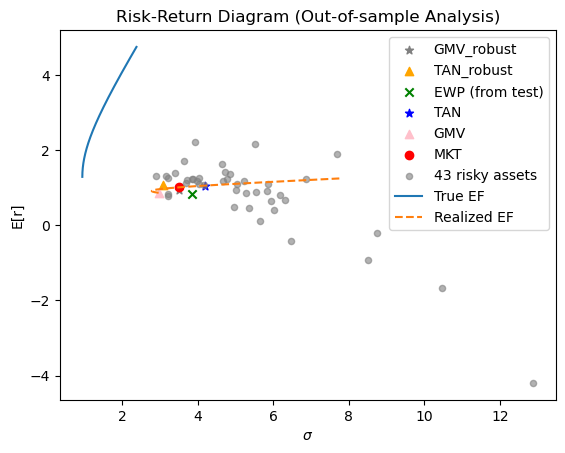

<Figure size 2000x2000 with 0 Axes>

In [22]:
#plot gmv-robust
plt.scatter(metric_gmv_robust['sigma'], metric_gmv_robust['Er'], 
            marker='*', color = 'grey',label = 'GMV_robust')

#plot tan-robust 
plt.scatter(metric_tan_robust['sigma'], metric_tan_robust['Er'],
            marker='^', color = 'orange',label = 'TAN_robust')

#plot the EWP 
plt.scatter(metric_ewp['sigma'], metric_ewp['Er'], 
            marker='x', color = 'green',label = 'EWP (from test)')

#plot tangency 
plt.scatter(metric_tan['sigma'], metric_tan['Er'], 
            marker='*', color = 'blue',label = 'TAN')

#plot GMV
plt.scatter(metric_gmv['sigma'], metric_gmv['Er'], 
            marker='^', color = 'pink',label = 'GMV')

#plot the MKT portfolio
plt.scatter(mkt_sd_test, mkt_er_test,marker='o', color='r',label="MKT")

#plot the 43 risky assets 
plt.scatter(sd_test, er_test ,marker='o', color='grey',s=20,alpha=0.6,label="43 risky assets")

#true EF: portfolio constructed & eval on test data
sigma_range_test, Er_range_test = get_EF_on_data (w_t_test, w_g_test, data_test)
plt.plot(sigma_range_test, Er_range_test, label = 'True EF')

#realised EF: portfolio constucted from training, evaluated against test
sigma_realized_range, Er_realized_range = get_EF_on_data (w_t_train, w_g_train, data_test)
plt.plot(sigma_realized_range, Er_realized_range, '--', label = 'Realized EF')


plt.legend()
plt.title('Risk-Return Diagram (Out-of-sample Analysis)')
plt.xlabel('$\sigma$')
plt.ylabel('E[r]')
plt.figure(figsize=(20, 20))
plt.show()

In [23]:
# getting performance metrics summary
performance_summary_test = pd.DataFrame({
    'Portfolio': ['MKT', 'EWP', 'TAN', 'GMV', 'TAN-robust', 'GMV-robust'],
    'Expected Return': [mkt_er_test, metric_ewp['Er'], metric_tan['Er'], metric_gmv['Er'], metric_tan_robust['Er'], metric_gmv_robust['Er']],
    'Standard Deviation': [mkt_sd_test, metric_ewp['sigma'], metric_tan['sigma'], metric_gmv['sigma'], metric_tan_robust['sigma'], metric_gmv_robust['sigma']],
    'Sharpe Ratio': [mkt_sharpe_test, metric_ewp['Sharpe'], metric_tan['Sharpe'], metric_gmv['Sharpe'], metric_tan_robust['Sharpe'], metric_gmv_robust['Sharpe']]
})


# Set the 'Portfolio' column as the index for better visualization
performance_summary_test.set_index('Portfolio', inplace=True)

# Display the summary table 3x6
performance_summary_test.T

Portfolio,MKT,EWP,TAN,GMV,TAN-robust,GMV-robust
Expected Return,1.010833,0.822671,1.055857,0.863082,1.074947,0.947527
Standard Deviation,3.502378,3.858277,4.201550,2.963800,3.083566,3.511392
Sharpe Ratio,0.288613,0.213222,0.251302,0.291208,0.348605,0.269844


In [24]:
w_t_robust

array([-0.01818913,  0.07826539, -0.06974743, -0.06158423, -0.11408941,
       -0.05234231, -0.10224801,  0.09301117,  0.240428  , -0.11445895,
       -0.11449993,  0.22459293, -0.04536578, -0.0897287 ,  0.03519799,
       -0.11471954,  0.05082913, -0.15333605, -0.05076644,  0.01161301,
        0.36870216, -0.13557482, -0.10998105, -0.12026341, -0.07727106,
        0.01632926, -0.04471716,  0.0667332 , -0.09057723,  0.10233526,
        0.41571972,  0.08954828, -0.08277752,  0.00566729,  0.05211462,
       -0.02241898, -0.16080477,  0.13813965,  0.03951002,  0.19146167,
        0.4205133 ,  0.18338119,  0.12136864])

# Data Challenge
- the training data and test data would be the same as 1.3, instead of randomly shuffling in order to preserve temporality of the historical data. 

In [25]:
def evaluate_portfolio_performance(w, mu, V, rf = 0):
    
    ###########
    # Evaluate the performance of a portfolio (i.e., weight vector) given the expected return vector
    # and covariance matrix
    # Input: mu is the expected return vector, V is the covariance matrix, and rf is the risk free rate (default 0)
    #        w is the portfolio weight vector
    # Output: The performance metrics of the portfolio 
    #         (i.e., expected return, standard deviation, variance, and Sharpe ratio)
    ###########
    
    # Sanity check for the input format
    if V.shape[0] != V.shape[1]:
        print('Warning: V should be a square matrix')
    #weights and mean returns are reshaped into a 1D vector
    w = w.reshape((-1))
    mu = mu.reshape((-1))
    if (len(mu) != len(w)) or (V.shape[0] != len(mu)):
        print('Warning: mu, V, and w should contain the same number of assets')
    ### End of sanity check
    
    #  the @ operator is used to perform matrix multiplication between two arrays or matrices.
    # .T means transpose
    return {'Er': mu.T @ w, 'sigma': np.sqrt(w.T @ V @ w), 
            'var': w.T @ V @ w, 'Sharpe': (mu.T @ w - rf)/(np.sqrt(w.T @ V @ w)) }

### A1: 1.3 robust est & ineq_cons

In [26]:
#An initial guess of the weights (equal)
w0 = np.random.rand(43)
w0 /= np.sum(w0)
# setting up the eq constraints 
eq_cons = {'type': 'eq', 'fun': lambda w: np.sum(w) - 1}  # sum(w) = 1

#inequality con works by enforcing that w_i greater than or equal to zero
ineq_cons ={'type': 'ineq', 'fun': lambda w: w}


#construct based on training Dataset
res_t1 = opt.minimize(lambda w: - evaluate_portfolio_performance(w,mu_CAPM_test.values,V_shrink_test, rf=0)['Sharpe'] 
                     , w0, method='SLSQP', constraints=[eq_cons,ineq_cons], options={'ftol': 1e-11, 'disp': True})

print(np.round(res_t1.x,5))

# testing this on the data_test 
print("Test data performance: ")
print(evaluate_portfolio_performance_on_data(res_t1.x,data_test))
print("================================")
print("Training data performance: ")
print(evaluate_portfolio_performance_on_data(res_t1.x,data_train))

Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.311904914393836
            Iterations: 29
            Function evaluations: 1276
            Gradient evaluations: 29
[-0.       0.      -0.       0.24488 -0.       0.      -0.      -0.
  0.08139 -0.      -0.      -0.      -0.      -0.       0.      -0.
  0.      -0.       0.      -0.      -0.      -0.      -0.      -0.
 -0.       0.03146 -0.      -0.      -0.       0.       0.11858 -0.
 -0.       0.1561  -0.      -0.       0.      -0.      -0.      -0.
  0.17155 -0.       0.19604]
Test data performance: 
{'Er': 1.175068302311171, 'sigma': 2.57631616349772, 'var': 6.637404974299611, 'Sharpe': 0.4561040756410295}
Training data performance: 
{'Er': 0.7020567022944771, 'sigma': 4.181218325144438, 'var': 17.48258668252366, 'Sharpe': 0.16790720974136766}


### A1.1 modified 1.3 robust est to optimised with new ineq_cons

In [27]:
from scipy.optimize import minimize
#making sure robust shrinkage coeffs are optimal
# Modify beta shrink function to accept a shrink coefficient
def estimate_beta_shrink1(data, market_excess, shrink_coef=0.5):
    beta_hat = data.apply(lambda x: estimate_beta_cov(x, market_excess))
    beta_avg = beta_hat.mean()
    beta_shrink = shrink_coef * beta_hat + (1 - shrink_coef) * beta_avg
    return beta_shrink

# Modify covariance shrink function to accept a shrink coefficient
def estimate_shrink_cov_m1(data, shrink_coef=0.7):
    V_hat = estimate_V(data)
    V_cc = np.zeros((43, 43))
    var = data.var().values
    corr = data.corr().values
    common_corr = np.sum(corr) / ((43 * 42) / 2)
    
    for i in range(43):
        for j in range(43):
            V_cc[i, j] = var[i] if i == j else np.sqrt(var[i] * var[j]) * common_corr

    V_shrink = shrink_coef * V_cc + (1 - shrink_coef) * V_hat
    return V_shrink

# Function to compute Sharpe ratio for given beta and covariance shrink coefficients
def objective_shrink_coefs1(coefs, data, market_excess, data_mkt, rf=0):
    beta_shrink_coef, cov_shrink_coef = coefs
    beta_shrink = estimate_beta_shrink1(data, market_excess, shrink_coef=beta_shrink_coef)
    mu = estimate_exp_return(beta_shrink, data_mkt)
    V = estimate_shrink_cov_m1(data, shrink_coef=cov_shrink_coef)
    
    #An initial guess of the weights (equal)
    w0 = np.random.rand(43)
    w0 /= np.sum(w0)
    # setting up the eq constraints 
    eq_cons = {'type': 'eq', 'fun': lambda w: np.sum(w) - 1}  # sum(w) = 1

    #inequality con works by enforcing that w_i greater than or equal to zero
    ineq_cons ={'type': 'ineq', 'fun': lambda w: w}
    
    # Optimize portfolio weights for Sharpe ratio
    res = minimize(
        lambda w: -evaluate_portfolio_performance(w, mu.values, V, rf)['Sharpe'],
        w0,
        method='SLSQP',
        constraints=[eq_cons,ineq_cons],
        options={'ftol': 1e-11, 'disp': False}
    )
    return -res.fun  # Return negative Sharpe ratio to maximize it

# Initial guess for shrink coefficients
shrink_coefs0 = [0.5, 0.7]

# Perform optimization for shrink coefficients
res_shrink = minimize(
    objective_shrink_coefs1, shrink_coefs0,
    args=(data_train, data_train_m['Mkt-RF'], data, 0),
    bounds=[(0, 1), (0, 1)],
    method='SLSQP'
)

# Optimal shrink coefficients
optimal_beta_shrink_coef2, optimal_cov_shrink_coef2 = res_shrink.x
print("Optimal beta shrink coefficient:", optimal_beta_shrink_coef2)
print("Optimal covariance shrink coefficient:", optimal_cov_shrink_coef2)

/var/folders/yt/y5_mktzd733fhq8w6gsryyn40000gp/T/ipykernel_3372/2890995068.py:24: RuntimeWarning: invalid value encountered in sqrt
  return {'Er': mu.T @ w, 'sigma': np.sqrt(w.T @ V @ w),
/var/folders/yt/y5_mktzd733fhq8w6gsryyn40000gp/T/ipykernel_3372/2890995068.py:25: RuntimeWarning: invalid value encountered in sqrt
  'var': w.T @ V @ w, 'Sharpe': (mu.T @ w - rf)/(np.sqrt(w.T @ V @ w)) }


Optimal beta shrink coefficient: 0.8414131636354789
Optimal covariance shrink coefficient: 0.9281535536296727


In [28]:
# constructing robust estimators based on the train data
beta_shrink_t2 = estimate_beta_shrink1(data_test, data_test_m['Mkt-RF'], shrink_coef=optimal_beta_shrink_coef2)
mu_CAPM_t2 = estimate_exp_return(beta_shrink_t2,data_test_m)
V_shrink_t2 = estimate_shrink_cov_m1(data_test, shrink_coef=optimal_cov_shrink_coef2)

#w_t_robust_1 = tangency(mu_CAPM_1 , V_shrink_1)
#print(w_t_robust_1)

#An initial guess of the weights (equal)
w0 = np.random.rand(43)
w0 /= np.sum(w0)
# setting up the eq constraints 
eq_cons = {'type': 'eq', 'fun': lambda w: np.sum(w) - 1}  # sum(w) = 1

#inequality con works by enforcing that w_i greater than or equal to zero
ineq_cons ={'type': 'ineq', 'fun': lambda w: w}

res_t2 = opt.minimize(lambda w: - evaluate_portfolio_performance(w,mu_CAPM_t2.values,V_shrink_t2, rf=0)['Sharpe'] 
                     , w0, method='SLSQP', constraints=[eq_cons,ineq_cons], options={'ftol': 1e-11, 'disp': True})

#Displaying the optimization solution
np.round(res_t2.x,5)

Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.27396409831781043
            Iterations: 19
            Function evaluations: 792
            Gradient evaluations: 18


array([ 0., -0., -0.,  0., -0., -0.,  0., -0., -0.,  0., -0.,  0., -0.,
       -0., -0.,  0.,  0.,  0.,  0.,  0., -0., -0.,  0., -0.,  0., -0.,
        0.,  0.,  0.,  0., -0., -0., -0.,  0., -0., -0., -0.,  0.,  0.,
       -0.,  1., -0., -0.])

In [29]:
# Constraint to enforce minimum weight
min_weight_constraint = {'type': 'ineq', 'fun': lambda w: w - 1/43}
res_t2_1 = opt.minimize(lambda w: - evaluate_portfolio_performance(w,mu_CAPM_t2.values,V_shrink_t2, rf=0)['Sharpe'] 
                     , w0, method='SLSQP', constraints=[eq_cons,ineq_cons,min_weight_constraint], options={'ftol': 1e-11, 'disp': True})

#Displaying the optimization solution
print(np.round(res_t2.x,5))
print("Test data performance: ")
print(evaluate_portfolio_performance_on_data(res_t2_1.x,data_test))
print("================================")
print("Training data performance: ")
print(evaluate_portfolio_performance_on_data(res_t2_1.x,data_train))

Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.19981848246620107
            Iterations: 2
            Function evaluations: 88
            Gradient evaluations: 2
[ 0. -0. -0.  0. -0. -0.  0. -0. -0.  0. -0.  0. -0. -0. -0.  0.  0.  0.
  0.  0. -0. -0.  0. -0.  0. -0.  0.  0.  0.  0. -0. -0. -0.  0. -0. -0.
 -0.  0.  0. -0.  1. -0. -0.]
Test data performance: 
{'Er': 0.8226705426356564, 'sigma': 3.858277189719393, 'var': 14.886302872708974, 'Sharpe': 0.21322224977192167}
Training data performance: 
{'Er': 0.6974829457364343, 'sigma': 4.792854129683646, 'var': 22.971450708425582, 'Sharpe': 0.1455255943252485}


In [30]:
max_assets_constraint = {
    'type': 'ineq',
    'fun': lambda w: 33 - np.sum(w < 1/43) #max of 10 assets in portfolio
}
res_t2_2 = opt.minimize(lambda w: - evaluate_portfolio_performance(w,mu_CAPM_t2.values,V_shrink_t2, rf=0)['Sharpe'] 
                     , w0, method='SLSQP', constraints=[eq_cons,ineq_cons,max_assets_constraint], options={'ftol': 1e-11, 'disp': True})

#Displaying the optimization solution
print(np.round(res_t2_2.x,5))
print("Test data performance: ")
print(evaluate_portfolio_performance_on_data(res_t2_2.x,data_test))
print("================================")
print("Training data performance: ")
print(evaluate_portfolio_performance_on_data(res_t2_2.x,data_train))

/var/folders/yt/y5_mktzd733fhq8w6gsryyn40000gp/T/ipykernel_3372/2890995068.py:24: RuntimeWarning: invalid value encountered in sqrt
  return {'Er': mu.T @ w, 'sigma': np.sqrt(w.T @ V @ w),
/var/folders/yt/y5_mktzd733fhq8w6gsryyn40000gp/T/ipykernel_3372/2890995068.py:25: RuntimeWarning: invalid value encountered in sqrt
  'var': w.T @ V @ w, 'Sharpe': (mu.T @ w - rf)/(np.sqrt(w.T @ V @ w)) }


Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -0.33283263712378125
            Iterations: 93
            Function evaluations: 4348
            Gradient evaluations: 89
[ 0.00000e+00 -1.39600e-02  0.00000e+00  1.37100e-02 -0.00000e+00
  1.08980e-01  0.00000e+00  4.25000e-02  8.00000e-05 -0.00000e+00
 -0.00000e+00  1.52850e-01 -2.44800e-02  1.64370e-01  1.04300e-01
 -9.42000e-03  4.30000e-04 -0.00000e+00 -0.00000e+00 -0.00000e+00
 -0.00000e+00 -0.00000e+00 -0.00000e+00 -4.99150e-01  0.00000e+00
  0.00000e+00  0.00000e+00 -0.00000e+00  0.00000e+00  0.00000e+00
  0.00000e+00 -4.08510e-01  0.00000e+00  2.12920e-01  1.30890e-01
  4.60500e-02  0.00000e+00  1.18384e+00 -5.38830e-01  0.00000e+00
  1.10085e+00 -7.55040e-01 -1.24000e-02]
Test data performance: 
{'Er': 0.8434149644843036, 'sigma': 5.180705483971523, 'var': 26.839709311652612, 'Sharpe': 0.16279924946394417}
Training data performance: 
{'Er': 0.28808480442418893, 'sigma': 8.220

In [31]:
# new robust shrinkage coefs:[eq_cons,ineq_cons,max_assets_constraint=10] 
# found to overfit the least but no improvement over old shrinkage coef

# conclusion: best performance obtained with the beta shrink, V shrink method is 
# through constraints of same shrink in 1.3
# and new constraints of ineq_cons (res_t1.x)

### A2: returns shrinkage estimator 
- getting the optimal shrinkage value

In [32]:
# Trying return shrink instead of CAPM, constraints = eq_cons

# Modify beta shrink function to accept a shrink coefficient
def estimate_return_shrink(data, shrink_coef=0.5):
    hist_mean = data.mean()
    grand_avg_mean = hist_mean.mean()
    return_shrink =  shrink_coef * grand_avg_mean + (1 - shrink_coef) * hist_mean
    return return_shrink

# Function to compute Sharpe ratio for given return and covariance shrink coefficients
def objective_shrink_coefs3(coefs, data, market_excess, data_mkt, rf=0):
    return_shrink_coef, cov_shrink_coef = coefs
    mu_shrink = estimate_return_shrink(data, shrink_coef=return_shrink_coef)
    V_shrink = estimate_shrink_cov_m1(data, shrink_coef=cov_shrink_coef)
    
    #An initial guess of the weights (equal)
    w0 = np.random.rand(43)
    w0 /= np.sum(w0)
    # setting up the eq constraints 
    eq_cons = {'type': 'eq', 'fun': lambda w: np.sum(w) - 1}  # sum(w) = 1

    #inequality con works by enforcing that w_i greater than or equal to zero
    ineq_cons ={'type': 'ineq', 'fun': lambda w: w}
    
    max_assets_constraint = {
    'type': 'ineq',
    'fun': lambda w: 33 - np.sum(w < 1/43) 
    }
    
    # Optimize portfolio weights for Sharpe ratio
    res = minimize(
        lambda w: -evaluate_portfolio_performance(w, mu_shrink.values, V_shrink, rf)['Sharpe'],
        w0,
        method='SLSQP',
        constraints=[eq_cons],
        options={'ftol': 1e-11, 'disp': False}
    )
    return -res.fun  # Return negative Sharpe ratio to maximize it

# Initial guess for shrink coefficients
shrink_coefs0 = [0.5, 0.7]

# Perform optimization for shrink coefficients
res_shrink1 = minimize(
    objective_shrink_coefs3, shrink_coefs0,
    args=(data_train, data_train_m['Mkt-RF'], data1, 0),
    bounds=[(0, 1), (0, 1)],
    method='SLSQP'
)

# Optimal shrink coefficients
optimal_return_shrink_coef, optimal_cov_shrink_coef1 = res_shrink1.x
print("Optimal return shrink coefficient:", optimal_return_shrink_coef)
print("Optimal covariance shrink coefficient:", optimal_cov_shrink_coef1)


/var/folders/yt/y5_mktzd733fhq8w6gsryyn40000gp/T/ipykernel_3372/2890995068.py:24: RuntimeWarning: invalid value encountered in sqrt
  return {'Er': mu.T @ w, 'sigma': np.sqrt(w.T @ V @ w),
/var/folders/yt/y5_mktzd733fhq8w6gsryyn40000gp/T/ipykernel_3372/2890995068.py:25: RuntimeWarning: invalid value encountered in sqrt
  'var': w.T @ V @ w, 'Sharpe': (mu.T @ w - rf)/(np.sqrt(w.T @ V @ w)) }
/var/folders/yt/y5_mktzd733fhq8w6gsryyn40000gp/T/ipykernel_3372/2890995068.py:24: RuntimeWarning: invalid value encountered in sqrt
  return {'Er': mu.T @ w, 'sigma': np.sqrt(w.T @ V @ w),
/var/folders/yt/y5_mktzd733fhq8w6gsryyn40000gp/T/ipykernel_3372/2890995068.py:25: RuntimeWarning: invalid value encountered in sqrt
  'var': w.T @ V @ w, 'Sharpe': (mu.T @ w - rf)/(np.sqrt(w.T @ V @ w)) }


Optimal return shrink coefficient: 0.5
Optimal covariance shrink coefficient: 0.7


/var/folders/yt/y5_mktzd733fhq8w6gsryyn40000gp/T/ipykernel_3372/2890995068.py:24: RuntimeWarning: invalid value encountered in sqrt
  return {'Er': mu.T @ w, 'sigma': np.sqrt(w.T @ V @ w),
/var/folders/yt/y5_mktzd733fhq8w6gsryyn40000gp/T/ipykernel_3372/2890995068.py:25: RuntimeWarning: invalid value encountered in sqrt
  'var': w.T @ V @ w, 'Sharpe': (mu.T @ w - rf)/(np.sqrt(w.T @ V @ w)) }


In [33]:
# Trying return shrink instead of CAPM, constraints = eq_cons, ineq_cons
def objective_shrink_coefs4(coefs, data, market_excess, data_mkt, rf=0):
    return_shrink_coef, cov_shrink_coef = coefs
    mu_shrink = estimate_return_shrink(data, shrink_coef=return_shrink_coef)
    V_shrink = estimate_shrink_cov_m1(data, shrink_coef=cov_shrink_coef)
    
    #An initial guess of the weights (equal)
    w0 = np.random.rand(43)
    w0 /= np.sum(w0)
    # setting up the eq constraints 
    eq_cons = {'type': 'eq', 'fun': lambda w: np.sum(w) - 1}  # sum(w) = 1

    #inequality con works by enforcing that w_i greater than or equal to zero
    ineq_cons ={'type': 'ineq', 'fun': lambda w: w}
    
    max_assets_constraint = {
    'type': 'ineq',
    'fun': lambda w: 33 - np.sum(w < 1/43) 
    }
    
    # Optimize portfolio weights for Sharpe ratio
    res = minimize(
        lambda w: -evaluate_portfolio_performance(w, mu_shrink.values, V_shrink, rf)['Sharpe'],
        w0,
        method='SLSQP',
        constraints=[eq_cons,ineq_cons],
        options={'ftol': 1e-11, 'disp': False}
    )
    return -res.fun  # Return negative Sharpe ratio to maximize it

# Initial guess for shrink coefficients
shrink_coefs0 = [0.5, 0.7]

# Perform optimization for shrink coefficients
res_shrink2 = minimize(
    objective_shrink_coefs4, shrink_coefs0,
    args=(data_train, data_train_m['Mkt-RF'], data1, 0),
    bounds=[(0, 1), (0, 1)],
    method='SLSQP'
)

# Optimal shrink coefficients
optimal_return_shrink_coef2, optimal_cov_shrink_coef2 = res_shrink2.x
print("Optimal return shrink coefficient:", optimal_return_shrink_coef2)
print("Optimal covariance shrink coefficient:", optimal_cov_shrink_coef2)


Optimal return shrink coefficient: 0.5870519392557455
Optimal covariance shrink coefficient: 0.8712312621790418


In [34]:
# Trying return shrink instead of CAPM, constraints = eq_cons, ineq_cons, max_assets_constraints (max 10)
def objective_shrink_coefs5(coefs, data, market_excess, data_mkt, rf=0):
    return_shrink_coef, cov_shrink_coef = coefs
    mu_shrink = estimate_return_shrink(data, shrink_coef=return_shrink_coef)
    V_shrink = estimate_shrink_cov_m1(data, shrink_coef=cov_shrink_coef)
    
    #An initial guess of the weights (equal)
    w0 = np.random.rand(43)
    w0 /= np.sum(w0)
    # setting up the eq constraints 
    eq_cons = {'type': 'eq', 'fun': lambda w: np.sum(w) - 1}  # sum(w) = 1

    #inequality con works by enforcing that w_i greater than or equal to zero
    ineq_cons ={'type': 'ineq', 'fun': lambda w: w}
    
    max_assets_constraint = {
    'type': 'ineq',
    'fun': lambda w: 33 - np.sum(w < 1/43) 
    }
    
    # Optimize portfolio weights for Sharpe ratio
    res = minimize(
        lambda w: -evaluate_portfolio_performance(w, mu_shrink.values, V_shrink, rf)['Sharpe'],
        w0,
        method='SLSQP',
        constraints=[eq_cons,ineq_cons,max_assets_constraint],
        options={'ftol': 1e-11, 'disp': False}
    )
    return -res.fun  # Return negative Sharpe ratio to maximize it

# Initial guess for shrink coefficients
shrink_coefs0 = [0.5, 0.7]

# Perform optimization for shrink coefficients
res_shrink3 = minimize(
    objective_shrink_coefs5, shrink_coefs0,
    args=(data_train, data_train_m['Mkt-RF'], data1, 0),
    bounds=[(0, 1), (0, 1)],
    method='SLSQP'
)

# Optimal shrink coefficients
optimal_return_shrink_coef3, optimal_cov_shrink_coef3 = res_shrink3.x
print("Optimal return shrink coefficient:", optimal_return_shrink_coef3)
print("Optimal covariance shrink coefficient:", optimal_cov_shrink_coef3)


/var/folders/yt/y5_mktzd733fhq8w6gsryyn40000gp/T/ipykernel_3372/2890995068.py:24: RuntimeWarning: invalid value encountered in sqrt
  return {'Er': mu.T @ w, 'sigma': np.sqrt(w.T @ V @ w),
/var/folders/yt/y5_mktzd733fhq8w6gsryyn40000gp/T/ipykernel_3372/2890995068.py:25: RuntimeWarning: invalid value encountered in sqrt
  'var': w.T @ V @ w, 'Sharpe': (mu.T @ w - rf)/(np.sqrt(w.T @ V @ w)) }
/var/folders/yt/y5_mktzd733fhq8w6gsryyn40000gp/T/ipykernel_3372/2890995068.py:24: RuntimeWarning: invalid value encountered in sqrt
  return {'Er': mu.T @ w, 'sigma': np.sqrt(w.T @ V @ w),
/var/folders/yt/y5_mktzd733fhq8w6gsryyn40000gp/T/ipykernel_3372/2890995068.py:25: RuntimeWarning: invalid value encountered in sqrt
  'var': w.T @ V @ w, 'Sharpe': (mu.T @ w - rf)/(np.sqrt(w.T @ V @ w)) }
/var/folders/yt/y5_mktzd733fhq8w6gsryyn40000gp/T/ipykernel_3372/2890995068.py:24: RuntimeWarning: invalid value encountered in sqrt
  return {'Er': mu.T @ w, 'sigma': np.sqrt(w.T @ V @ w),
/var/folders/yt/y5_mktz

Optimal return shrink coefficient: 0.4990135733579429
Optimal covariance shrink coefficient: 0.7002891701967513


## A2.1

In [35]:
# with eq_cons, in eqcons and max asset cons
return_shrink3 = estimate_return_shrink(data_test,shrink_coef=optimal_return_shrink_coef3)
V_shrink3 = estimate_shrink_cov_m1(data_test,shrink_coef=optimal_cov_shrink_coef3)


res_t3 = opt.minimize(lambda w: - evaluate_portfolio_performance(w,return_shrink3.values,V_shrink3, rf=0)['Sharpe'] 
                     , w0, method='SLSQP', constraints=[eq_cons,ineq_cons,max_assets_constraint]
                      , options={'ftol': 1e-11, 'disp': True})

# Displaying the optimized portfolio weights
optimized_weights = np.round(res_t3.x,3)
print("Optimized Portfolio Weights:", optimized_weights)

# Calculating and displaying performance metrics
portfolio_performance = evaluate_portfolio_performance(res_t3.x, return_shrink3.values,V_shrink3, rf=0)
print("Portfolio Performance:", portfolio_performance)


print("Test data performance: ")
print(evaluate_portfolio_performance_on_data(res_t3.x,data_test))
print("================================")
print("Training data performance: ")
print(evaluate_portfolio_performance_on_data(res_t3.x,data_train))

Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -0.19020049977798378
            Iterations: 91
            Function evaluations: 4167
            Gradient evaluations: 87
Optimized Portfolio Weights: [-1.20982940e+09  5.87168786e+09  1.27000000e-01  3.82368736e+10
 -7.61072074e+09  8.56415010e+04 -5.67400430e+04  9.72332430e+04
 -2.42574497e+09 -1.74196826e+09  1.39118818e+05 -1.91791908e+09
  1.46823739e+10 -8.73842930e+04 -1.30653692e+09 -7.69618313e+08
 -6.35359263e+07  2.78126540e+04 -2.14095674e+05  1.18596136e+05
 -1.33067018e+05  1.30416531e+05 -1.63399052e+05 -3.21578404e+07
 -1.55896921e+08  1.89088024e+10 -2.79328890e+04 -5.55383460e+04
  5.51647990e+04 -2.90796096e+05 -1.54734484e+07 -1.36083970e+09
  1.65914660e+04 -1.04538901e+09  1.12778880e+05  2.59461820e+04
  5.07211660e+04 -6.77583370e+04  2.22273100e+04 -5.76027340e+04
  3.65966009e+08 -4.52002370e+10 -1.32095642e+10]
Portfolio Performance: {'Er': 9510306736.126884

In [36]:
# with eq_cons, in eqcons
return_shrink2 = estimate_return_shrink(data_test,shrink_coef=optimal_return_shrink_coef2)
V_shrink2 = estimate_shrink_cov_m1(data_test,shrink_coef=optimal_cov_shrink_coef2)


res_t4 = opt.minimize(lambda w: - evaluate_portfolio_performance(w,return_shrink2.values,V_shrink2, rf=0)['Sharpe'] 
                     , w0, method='SLSQP', constraints=[eq_cons,ineq_cons]
                      , options={'ftol': 0.01, 'disp': True})

# Displaying the optimized portfolio weights
optimized_weights = np.round(res_t4.x, 5)
print("Optimized Portfolio Weights:", optimized_weights)

# Calculating and displaying performance metrics
portfolio_performance = evaluate_portfolio_performance(res_t4.x, return_shrink2.values,V_shrink2, rf=0)
print("Portfolio Performance:", portfolio_performance)


print("Test data performance: ")
print(evaluate_portfolio_performance_on_data(res_t4.x,data_test))
print("================================")
print("Training data performance: ")
print(evaluate_portfolio_performance_on_data(res_t4.x,data_train))

Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.3299752691984109
            Iterations: 4
            Function evaluations: 176
            Gradient evaluations: 4
Optimized Portfolio Weights: [-0.       0.12635 -0.       0.20708 -0.      -0.      -0.      -0.
 -0.      -0.      -0.      -0.       0.15272 -0.      -0.      -0.
 -0.      -0.      -0.      -0.      -0.      -0.      -0.      -0.
 -0.       0.30105 -0.      -0.      -0.      -0.      -0.      -0.
 -0.      -0.      -0.      -0.      -0.      -0.       0.      -0.
 -0.       0.09653  0.11627]
Portfolio Performance: {'Er': 1.16019678271676, 'sigma': 3.5160113227126275, 'var': 12.362335621443401, 'Sharpe': 0.3299752691984109}
Test data performance: 
{'Er': 1.6400281528706575, 'sigma': 2.6206794488608467, 'var': 6.867960773681592, 'Sharpe': 0.6258026534239213}
Training data performance: 
{'Er': 0.738791967318449, 'sigma': 4.243758812314835, 'var': 18.009488857099818, 'Sharpe': 0.1

In [37]:
# with eq_cons
return_shrink1 = estimate_return_shrink(data_test,shrink_coef=optimal_return_shrink_coef)
V_shrink1 = estimate_shrink_cov_m1(data_test,shrink_coef=optimal_cov_shrink_coef1)


res_t5 = opt.minimize(lambda w: - evaluate_portfolio_performance(w,return_shrink1.values,V_shrink1, rf=0)['Sharpe'] 
                     , w0, method='SLSQP', constraints=[eq_cons]
                      , options={'ftol': 0.1, 'disp': True})

# Displaying the optimized portfolio weights
optimized_weights = np.round(res_t5.x, 5)
print("Optimized Portfolio Weights:", optimized_weights)

# Calculating and displaying performance metrics
portfolio_performance = evaluate_portfolio_performance(res_t5.x, return_shrink1.values,V_shrink1, rf=0)
print("Portfolio Performance:", portfolio_performance)


print("Test data performance: ")
print(evaluate_portfolio_performance_on_data(res_t5.x,data_test))
print("================================")
print("Training data performance: ")
print(evaluate_portfolio_performance_on_data(res_t5.x,data_train))

Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.9999229952042513
            Iterations: 4
            Function evaluations: 181
            Gradient evaluations: 4
Optimized Portfolio Weights: [ 0.07884  0.02376  0.01009  0.02595  0.1489   0.03007  0.09394  0.02596
 -0.06064  0.05786  0.05165  0.00745  0.08941  0.05233  0.08555  0.25219
  0.06987  0.04788 -0.12544 -0.0288   0.03862 -0.0501   0.00515  0.00694
  0.35703  0.2736   0.01025 -0.11031 -0.50709 -0.0133  -0.02416  0.00547
 -0.02826  0.0338  -0.0824   0.04375  0.05273 -0.04207 -0.01607 -0.0039
  0.06326  0.02902  0.02122]
Portfolio Performance: {'Er': 3.0853550300938393, 'sigma': 3.0855926355245016, 'var': 9.52088191240304, 'Sharpe': 0.9999229952042513}
Test data performance: 
{'Er': 5.348039517552018, 'sigma': 6.893275439726096, 'var': 47.517246287930995, 'Sharpe': 0.7758342988488681}
Training data performance: 
{'Er': 0.20043278968529388, 'sigma': 8.109623077056519, 'var': 65.76598

In [38]:
# r_shrink: estimator
# v bad performanced obtained with [eq_cons and ineq_cons & max asset cons, likely due to the extreme positions] 
# performance from [ineq_cons, eq_cons]
# may be better than with the beta, capm and Vshrink method (eq_cons & ineq_cons), but could have overfitted

### A1.3 1.3 robust est and constraints = eq_cons, ineq_cons, max_assets_constraint (max=10)

In [39]:
# beta, mean capm and v shrink method with more constraints

#construct based on training Dataset
res_t1_3 = opt.minimize(lambda w: - evaluate_portfolio_performance(w,mu_CAPM_test.values,V_shrink_test, rf=0)['Sharpe'] 
                     , w0, method='SLSQP', constraints=[eq_cons,ineq_cons,max_assets_constraint], options={'ftol': 1e-11, 'disp': True})

print(np.round(res_t1_3.x,5))

# testing this on the data_test 
print("Test data performance: ")
print(evaluate_portfolio_performance_on_data(res_t1_3.x,data_test))
print("================================")
print("Training data performance: ")
print(evaluate_portfolio_performance_on_data(res_t1_3.x,data_train))

Iteration limit reached    (Exit mode 9)
            Current function value: -0.31173327689356045
            Iterations: 100
            Function evaluations: 4809
            Gradient evaluations: 100
[ 0.       0.02335 -0.       0.20802 -0.      -0.       0.      -0.
  0.08439 -0.      -0.       0.      -0.      -0.      -0.      -0.
  0.       0.       0.       0.       0.      -0.      -0.      -0.
  0.       0.03378  0.       0.       0.      -0.       0.13172 -0.
  0.       0.16709 -0.      -0.      -0.      -0.       0.      -0.
  0.14483  0.02326  0.18358]
Test data performance: 
{'Er': 1.1757247853162098, 'sigma': 2.574683976868702, 'var': 6.628997580744437, 'Sharpe': 0.45664819289632247}
Training data performance: 
{'Er': 0.7004983758936629, 'sigma': 4.142977885010821, 'var': 17.16426575568874, 'Sharpe': 0.1690808870662927}


In [40]:
## best results gained from the 1.3 robust estimator

### A3 Using simulated historical returns to get new data

In [41]:
# Estimating future historical returns by simulation, 
# where historical simulation follows a random normal dist
# Set a random seed for reproducibility
np.random.seed(42)

#og dataset, without monthly column
data_mkt = data.iloc[:,1:]
data_mkt

# Parameters for the simulation
n_assets = 45             # Number of assets + mkt RF & Rf
n_months = 360            # Number of months to simulate
n_scenarios = 200        # Number of simulation paths/scenarios

# Historical data of returns (in %), shape should be (360, 43) as per your dataset description
# Assuming data1 is already loaded with returns in %.
historical_returns = data_mkt.values / 100  # Convert % to decimal for calculations

# Calculate the mean and standard deviation of returns for each asset based on historical data
mean_returns = np.mean(historical_returns, axis=0)
std_devs = np.std(historical_returns, axis=0)

# Initialize an array to hold simulated returns
simulated_returns = np.zeros((n_months, n_assets, n_scenarios))

# Monte Carlo simulation for each asset and each scenario
for scenario in range(n_scenarios):
    for asset in range(n_assets):
        # Generate random returns for each asset for 360 months
        simulated_returns[:, asset, scenario] = np.random.normal(
            mean_returns[asset], std_devs[asset], n_months
        )

# Convert the simulated returns array to a DataFrame for easier handling
# Each scenario will have its own DataFrame for monthly returns
simulated_dfs = []
for scenario in range(n_scenarios):
    df_simulation = pd.DataFrame(simulated_returns[:, :, scenario], columns=[f'Asset_{i+1}' for i in range(n_assets)])
    df_simulation['Month'] = np.arange(1, n_months + 1)  # Add month index
    df_simulation['Scenario'] = scenario + 1  # Scenario identifier
    simulated_dfs.append(df_simulation)

# Concatenate all scenarios into a single DataFrame
simulated_data = pd.concat(simulated_dfs, ignore_index=True)

# Rearrange columns: Scenario, Month, then assets
simulated_data = simulated_data[['Scenario', 'Month'] + [f'Asset_{i+1}' for i in range(n_assets)]]

asset_columns = data.columns[1:]
# Set the column names to match the ones in 'data_train' (assuming they match in order)
simulated_data.columns = ['Scenario', 'Month'] + asset_columns.tolist()


In [42]:
simulated_data

,Scenario,Month,Mkt-RF,RF,Agric,Food,Soda,Beer,Smoke,Toys,...,BusSv,Comps,Chips,LabEq,Paper,Boxes,Trans,Whlsl,Rtail,Meals
0,1,1,0.028608,0.003896,0.026681,-0.007134,0.055346,0.106879,-0.063463,0.017044,...,0.090691,0.091950,-0.051332,-0.108898,-0.040101,0.004630,-0.030346,-0.044573,-0.008736,0.010489
1,1,2,0.000172,0.006013,-0.102292,-0.007161,0.091049,0.006825,0.029400,0.205238,...,0.000744,0.088379,-0.057873,0.032747,-0.025182,-0.071194,0.029973,0.012728,-0.005939,-0.035367
2,1,3,0.035369,0.002583,-0.079157,-0.005933,0.021653,-0.026210,0.046613,0.029921,...,-0.015199,-0.067277,0.118375,-0.040304,0.076723,0.061075,-0.108665,0.034440,-0.066787,-0.025997
3,1,4,0.074569,0.003650,0.054512,0.100709,-0.081684,-0.067280,0.090510,-0.015687,...,-0.013900,0.131841,0.009818,0.066948,-0.035397,0.053307,-0.019293,0.036270,-0.017688,0.235030
4,1,5,-0.004122,0.004253,0.017929,0.025351,0.036943,-0.082041,0.120626,0.067045,...,0.064934,-0.108010,0.053724,0.055335,0.013386,-0.033281,0.102708,0.002734,0.031267,0.059553
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71995,200,356,-0.005111,0.001283,0.030008,-0.005472,-0.073385,0.011164,0.018884,0.122022,...,-0.062670,-0.006365,0.133709,0.126107,-0.090567,-0.055559,-0.035973,0.020247,-0.019268,-0.073824
71996,200,357,0.052678,0.001417,-0.065140,-0.029407,0.161166,-0.025577,-0.057787,-0.142135,...,-0.054346,-0.159732,-0.014191,-0.046859,-0.125827,-0.075199,-0.008912,-0.028116,-0.016273,-0.087894
71997,200,358,-0.023136,0.003201,-0.043852,0.057266,0.078741,0.102435,-0.001665,0.046622,...,0.050449,0.046664,0.098039,0.052043,0.035102,-0.014177,-0.002852,-0.003240,-0.033240,-0.042760
71998,200,359,0.046409,0.004008,-0.062863,0.075534,0.015939,0.080925,0.018555,-0.055321,...,0.053063,-0.030904,0.007037,0.037330,0.073492,-0.023389,0.066518,-0.014816,-0.081328,0.031333


### A3.1 simulated data and 1.3 robust estimator & optimisation with eq_cons, ineq_cons

In [43]:
# getting a portfolio (TAN) based on the simulated data with beta, capm returns and Vshrink estimator
sim_data_train = simulated_data.iloc[:25200,4:]*100
sim_data_test = simulated_data.iloc[25200:,4:]*100

sim_data_train_m = simulated_data.iloc[:25200,1:]

sim_data_test_m = simulated_data.iloc[25200:,1:]

sim_beta_shrink = estimate_beta_shrink(sim_data_train, sim_data_train_m['Mkt-RF'])
sim_mu_CAPM = estimate_exp_return(sim_beta_shrink,sim_data_train_m)
sim_V_shrink = estimate_shrink_cov_m(sim_data_train)

#construct based on training Dataset
res_t6 = opt.minimize(lambda w: - evaluate_portfolio_performance(w,sim_mu_CAPM.values,sim_V_shrink, rf=0)['Sharpe'] 
                     , w0, method='SLSQP', constraints=[eq_cons,ineq_cons,max_assets_constraint], options={'ftol': 1e-11, 'disp': True})

print(np.round(res_t6.x,5))

# testing this on the sim data
print("Simulated Test data performance: ")
print(evaluate_portfolio_performance_on_data(res_t6.x,sim_data_test))
print("================================")
print("Simulated Training data performance: ")
print(evaluate_portfolio_performance_on_data(res_t6.x,sim_data_train))


# testing this on the data_test 
print("Test data performance: ")
print(evaluate_portfolio_performance_on_data(res_t6.x,data_test))
print("================================")
print("Training data performance: ")
print(evaluate_portfolio_performance_on_data(res_t6.x,data_train))

Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.0019102565001488025
            Iterations: 45
            Function evaluations: 1980
            Gradient evaluations: 45
[ 0.       0.       0.       0.0219  -0.       0.06569  0.       0.1306
  0.08836  0.03697  0.00148 -0.      -0.      -0.      -0.       0.
  0.       0.04229 -0.       0.17923  0.10296  0.0308  -0.       0.
  0.      -0.       0.       0.       0.       0.       0.       0.12842
 -0.       0.       0.00031  0.       0.       0.      -0.       0.
  0.02389  0.01339  0.13369]
Simulated Test data performance: 
{'Er': 0.5997683481661398, 'sigma': 2.073178027763688, 'var': 4.298067134802136, 'Sharpe': 0.2892990086399394}
Simulated Training data performance: 
{'Er': 0.5799974703795252, 'sigma': 2.055424595821659, 'var': 4.22477026910863, 'Sharpe': 0.2821789091940249}
Test data performance: 
{'Er': 0.7728487132684608, 'sigma': 4.111834972551768, 'var': 16.9071868414998, 'Sharpe':

In [44]:
#construct based on training Dataset
res_t6_1 = opt.minimize(lambda w: - evaluate_portfolio_performance(w,sim_mu_CAPM.values,sim_V_shrink, rf=0)['Sharpe'] 
                     , w0, method='SLSQP', constraints=[eq_cons,ineq_cons], options={'ftol': 1e-11, 'disp': True})

print(np.round(res_t6_1.x,5))

# testing this on the sim data
print("Simulated Test data performance: ")
print(evaluate_portfolio_performance_on_data(res_t6_1.x,sim_data_test))
print("================================")
print("Simulated Training data performance: ")
print(evaluate_portfolio_performance_on_data(res_t6_1.x,sim_data_train))


# testing this on the data_test 
print("Test data performance: ")
print(evaluate_portfolio_performance_on_data(res_t6_1.x,data_test))
print("================================")
print("Training data performance: ")
print(evaluate_portfolio_performance_on_data(res_t6_1.x,data_train))

Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.0019102565001488025
            Iterations: 45
            Function evaluations: 1980
            Gradient evaluations: 45
[ 0.       0.       0.       0.0219  -0.       0.06569  0.       0.1306
  0.08836  0.03697  0.00148 -0.      -0.      -0.      -0.       0.
  0.       0.04229 -0.       0.17923  0.10296  0.0308  -0.       0.
  0.      -0.       0.       0.       0.       0.       0.       0.12842
 -0.       0.       0.00031  0.       0.       0.      -0.       0.
  0.02389  0.01339  0.13369]
Simulated Test data performance: 
{'Er': 0.5997683481661398, 'sigma': 2.073178027763688, 'var': 4.298067134802136, 'Sharpe': 0.2892990086399394}
Simulated Training data performance: 
{'Er': 0.5799974703795252, 'sigma': 2.055424595821659, 'var': 4.22477026910863, 'Sharpe': 0.2821789091940249}
Test data performance: 
{'Er': 0.7728487132684608, 'sigma': 4.111834972551768, 'var': 16.9071868414998, 'Sharpe':

### A3.1 simulated data and tangency() function like in 1.2 In-sample

In [45]:
# getting a portfolio (TAN) based on the  simulated data 

sim_mu = estimate_mu(sim_data_train)
sim_V = estimate_V(sim_data_train)

res_t7 = opt.minimize(lambda w: - evaluate_portfolio_performance(w,sim_mu,sim_V, rf=0)['Sharpe'] 
                     , w0, method='SLSQP', constraints=[eq_cons,ineq_cons], options={'ftol': 1e-11, 'disp': True})
print(np.round(res_t7.x,5))
print("SIMULATED Test data performance: ")
print(evaluate_portfolio_performance_on_data(res_t7.x,sim_data_train))
print("================================")
print("SIMULATED Training data performance: ")
print(evaluate_portfolio_performance_on_data(res_t7.x,sim_data_test))


print("Test data performance: ")
print(evaluate_portfolio_performance_on_data(res_t7.x,data_test))
print("================================")
print("Training data performance: ")
print(evaluate_portfolio_performance_on_data(res_t7.x,data_train))

Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.8000199367367177
            Iterations: 39
            Function evaluations: 1772
            Gradient evaluations: 39
[0.02034 0.04964 0.02035 0.04555 0.03325 0.0151  0.01883 0.01668 0.03853
 0.02394 0.01702 0.04122 0.04806 0.02527 0.02208 0.0131  0.02116 0.01536
 0.00827 0.0047  0.01885 0.02894 0.01274 0.02447 0.01377 0.02521 0.00127
 0.01536 0.00371 0.0282  0.04492 0.026   0.01088 0.02617 0.01257 0.01532
 0.02063 0.0247  0.02372 0.0277  0.02661 0.03602 0.03381]
SIMULATED Test data performance: 
{'Er': 0.7650870057543147, 'sigma': 0.9563349244458901, 'var': 0.9145764877149263, 'Sharpe': 0.8000199367367177}
SIMULATED Training data performance: 
{'Er': 0.7705427927122082, 'sigma': 0.9550522382528981, 'var': 0.9121247777918705, 'Sharpe': 0.8068069597133055}
Test data performance: 
{'Er': 1.0749170213587538, 'sigma': 3.4217459656799725, 'var': 11.708345453647167, 'Sharpe': 0.3141428475813649}
Tr

# Evaluating all models performance on the simulated test data

In [46]:

print(evaluate_portfolio_performance_on_data(res_t1.x,sim_data_test))
print("....................")
print(evaluate_portfolio_performance_on_data(res_t2.x,sim_data_test))
print("....................")
print(evaluate_portfolio_performance_on_data(res_t3.x,sim_data_test))
print("....................")
print(evaluate_portfolio_performance_on_data(res_t4.x,sim_data_test))
print("....................")
print(evaluate_portfolio_performance_on_data(res_t5.x,sim_data_test))
print("....................")
print(evaluate_portfolio_performance_on_data(res_t1_3.x,sim_data_test))
print("....................")
print(evaluate_portfolio_performance_on_data(res_t6.x,sim_data_test))
print("....................")
print(evaluate_portfolio_performance_on_data(res_t6_1.x,sim_data_test))
print("....................")
print(evaluate_portfolio_performance_on_data(res_t7.x,sim_data_test))

{'Er': 0.7726701013408221, 'sigma': 2.1685983759802596, 'var': 4.70281891630422, 'Sharpe': 0.35629930829933243}
....................
{'Er': 0.5734984726483991, 'sigma': 4.8466523728897215, 'var': 23.490039223637567, 'Sharpe': 0.11832878212110391}
....................
{'Er': 8706412477.374084, 'sigma': 353581531051.5702, 'var': 1.2501989910077249e+23, 'Sharpe': 0.024623493346727567}
....................
{'Er': 0.8847215014574769, 'sigma': 2.4556484255129343, 'var': 6.030209189724152, 'Sharpe': 0.3602801982016936}
....................
{'Er': 1.0649253887447958, 'sigma': 7.412284026858306, 'var': 54.941954494818795, 'Sharpe': 0.14367034302598952}
....................
{'Er': 0.7685450653891901, 'sigma': 2.046721993418507, 'var': 4.189070918343026, 'Sharpe': 0.3755004675087989}
....................
{'Er': 0.5997683481661398, 'sigma': 2.073178027763688, 'var': 4.298067134802136, 'Sharpe': 0.2892990086399394}
....................
{'Er': 0.5997683481661398, 'sigma': 2.073178027763688, 'var': 4

In [47]:
# CHOOSING BEST MODEL: 
# (1)simulated data, and the beta, capm V shrink method 
print(np.round(res_t6.x,5))

# testing this on the data_test 
print(" Model performance: (Monte Carlo) & Beta, Returns CAPM & V shrink")
print("Simulated Test data performance: ")
print(evaluate_portfolio_performance_on_data(res_t6.x,data_test))
print("...................")

print(np.round(res_t7.x,5))

# testing this on the data_test 
print(" Model performance: (Monte Carlo) & Returns Shrink & V shrink")
print("Simulated Test data performance: ")
print(evaluate_portfolio_performance_on_data(res_t7.x,data_test))
print("...................")

# 1.3 beta, capm V shrink est 
# constraints = eq_cons, ineq_cons, max_assets_constraint (max=10)
print(np.round(res_t1.x,5))

# testing this on the data_test 
print(" Model performance: Historical Data & Beta Shrink, CAPM returns & V shrink (ineq_cons, eq_cons)")
print("Simulated Test data performance: ")
print(evaluate_portfolio_performance_on_data(res_t1.x,data_test))
print("....................")

print(np.round(res_t1_3.x,5))
print(" Model performance: Historical Data & Beta Shrink, CAPM returns & V shrink(ineq_cons, eq_cons, max assets cons)")
# testing this on the data_test 
print("Simulated Test data performance: ")
print(evaluate_portfolio_performance_on_data(res_t1_3.x,data_test))


[ 0.       0.       0.       0.0219  -0.       0.06569  0.       0.1306
  0.08836  0.03697  0.00148 -0.      -0.      -0.      -0.       0.
  0.       0.04229 -0.       0.17923  0.10296  0.0308  -0.       0.
  0.      -0.       0.       0.       0.       0.       0.       0.12842
 -0.       0.       0.00031  0.       0.       0.      -0.       0.
  0.02389  0.01339  0.13369]
 Model performance: (Monte Carlo) & Beta, Returns CAPM & V shrink
Simulated Test data performance: 
{'Er': 0.7728487132684608, 'sigma': 4.111834972551768, 'var': 16.9071868414998, 'Sharpe': 0.1879571331115066}
...................
[0.02034 0.04964 0.02035 0.04555 0.03325 0.0151  0.01883 0.01668 0.03853
 0.02394 0.01702 0.04122 0.04806 0.02527 0.02208 0.0131  0.02116 0.01536
 0.00827 0.0047  0.01885 0.02894 0.01274 0.02447 0.01377 0.02521 0.00127
 0.01536 0.00371 0.0282  0.04492 0.026   0.01088 0.02617 0.01257 0.01532
 0.02063 0.0247  0.02372 0.0277  0.02661 0.03602 0.03381]
 Model performance: (Monte Carlo) & Return

In [48]:
# Round the portfolio weights and check the sum
portfolio_weights = np.round(res_t1_3.x, 5)
sum_weights = np.sum(portfolio_weights)

# Print the portfolio weights and their sum
print("Portfolio Weights (Rounded):")
print(portfolio_weights)

print(f"Sum of Portfolio Weights: {sum_weights}")

Portfolio Weights (Rounded):
[ 0.       0.02335 -0.       0.20802 -0.      -0.       0.      -0.
  0.08439 -0.      -0.       0.      -0.      -0.      -0.      -0.
  0.       0.       0.       0.       0.      -0.      -0.      -0.
  0.       0.03378  0.       0.       0.      -0.       0.13172 -0.
  0.       0.16709 -0.      -0.      -0.      -0.       0.      -0.
  0.14483  0.02326  0.18358]
Sum of Portfolio Weights: 1.00002


In [49]:
results_train = pd.DataFrame(np.round(res_t1_3.x,2).reshape(1, 43), columns=data_train.columns)
results_train.loc[:, (results_train != 0).any(axis=0)]


,Food,Beer,Hshld,Guns,Util,BusSv,Whlsl,Rtail,Meals
0,0.02,0.21,0.08,0.03,0.13,0.17,0.14,0.02,0.18
